In [1]:
from __future__ import annotations
import typing

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import copy
import pickle
import time
from tqdm import tqdm

torch.manual_seed(3654)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Get text data

In [4]:
with open("data/text_corpus.txt", encoding="utf-8") as f:
    text = f.read()

print(len(text))

38739496


In [5]:
char_vocab = sorted(set(text))
char_vocab_size = len(char_vocab)
print(char_vocab_size)
print(char_vocab)

150
['\n', ' ', '!', '"', '$', '%', '&', "'", '+', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '´', 'É', 'Ö', 'Ü', 'á', 'ã', 'å', 'ç', 'è', 'é', 'ê', 'í', 'ó', 'ô', 'ö', 'ø', 'ù', 'ü', 'ć', 'ł', 'ő', 'Б', 'В', 'Г', 'Д', 'К', 'Н', 'П', 'Р', 'С', 'Т', 'У', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', '–', '—', '…', '가', '들', '어']


### Map characters to integers

In [6]:
# Create encoder and decoder dicts

char_int_mapping = dict()

for i, c in enumerate(sorted(set(text))):
    char_int_mapping[c] = i

### Byte Pair Encoding

In [7]:
# create the encoder dict
int_char_mapping = dict()

for key, item in char_int_mapping.items():
    int_char_mapping[item] = key

In [8]:
with open("data/text_corpus.txt", encoding="utf-8") as f:
    block_size = 10_000
    text = f.read()
    offset = np.random.randint(0, len(text) - block_size)
    text = text[offset:offset+block_size]

In [9]:
def bpe_tokenize_text(text):
    tokenized_text = []
    max_pair_len = max([len(k) for k in char_int_mapping.keys()])
    
    text_cpy = copy.copy(text)
    
    while text_cpy:
        # try to tokenize the different byte combinations from longest to shortest
        for i in range(5, 0, -1):
            byte = text_cpy[:i]
            byte_len = len(byte)
            #print(byte_len)
            
            if byte in char_int_mapping.keys():
                #print("match:", byte, "with len", byte_len)
                
                # append the tokenized byte to the list
                tokenized_text.append(
                    char_int_mapping[byte]
                )
                
                # remove encoded byte from the text
                text_cpy = text_cpy[byte_len:]
                #print(text_cpy)
                #print(tokenized_text)
                
                break
    return tokenized_text

In [10]:
""" Initialize the Mapping with the N most common Byte Pairs """

def add_byte_pair_to_mapping():
    
    # get new text sample block
    with open("data/text_corpus.txt", encoding="utf-8") as f:
        block_size = 500
        text = f.read()
        offset = np.random.randint(0, len(text) - block_size)
        text = text[offset:offset+block_size]
    
    # tokenize the text sample
    tokenized_text = bpe_tokenize_text(text)

    max_occurences = 0
    max_pair = None

    for byte1 in list(char_int_mapping.keys())[::-1]:
        for byte2 in list(char_int_mapping.keys())[::-1]:
            
            if byte1+byte2 in char_int_mapping.keys():
                break
              
            # encode the bytes
            sublist = bpe_tokenize_text(byte1+byte2)
            
            # get the occurence count of the byte pair (sublist of tokens)
            occurence_count = 0
            for i in range(len(tokenized_text)):
                if tokenized_text[i:i+len(sublist)] == sublist:
                    occurence_count += 1
            
            if occurence_count > max_occurences:
                max_occurences = occurence_count
                max_pair = byte1 + byte2
    
    # add the max pair to the mapping as a byte pair
    if max_pair is not None:
        char_int_mapping[max_pair] = max(char_int_mapping.values()) + 1
        return True
    else:
        return False

In [11]:
create_bpe = False

if create_bpe:
    
    max_mapping_size = 1_000
    for i in range(max_mapping_size - len(char_int_mapping)):
        added_pair = add_byte_pair_to_mapping()
        if added_pair:
            print(i, list(char_int_mapping.keys())[-1])
        else:
            print("---")

In [12]:
save_bpe_dict = False

if save_bpe_dict:
    with open('bpe_mapping.pkl', 'wb') as f:
        pickle.dump(char_int_mapping, f)

In [13]:
load_bpe_dict = True

if load_bpe_dict:
    with open('bpe_mapping.pkl', 'rb') as f:
        char_int_mapping = pickle.load(f)
        print(len(char_int_mapping))

1000


In [14]:
""" Example: Encode the text using a Byte Pair Encoding (BPE) """

with open("data/text_corpus.txt", encoding="utf-8") as f:
    block_size = 1_000
    text = f.read()
    offset = np.random.randint(0, len(text) - block_size)
    text = text[offset:offset+block_size]

tokenized_text = bpe_tokenize_text(text)
# print(tokenized_text)
print(len(tokenized_text))

534


In [15]:
# create the encoder dict (reverse mapping)

int_char_mapping = dict()

for key, item in char_int_mapping.items():
    int_char_mapping[item] = key

In [16]:
vocab_size = len(char_int_mapping)
print(vocab_size)

1000


### Encode the text dataset

In [17]:
def encode(string: str) -> List[int]:
    tokenized_text = bpe_tokenize_text(string)
    result = torch.tensor(tokenized_text, dtype=torch.long, device=device)
    return result

def decode(data:torch.tensor) -> str:
    string = [int_char_mapping[num] for num in data.tolist()]
    return "".join(string)

In [18]:
# 2M text len -> 114s (~2min) load time

114 / 60 * 38_739_496 / 2_000_000 # time in mins for encoding entire text

36.802521199999994

In [ ]:
# 0-5M done. (769s, 2708019 tokens) -> bpe_dataset1.pkl
# 5-10M TODO (837s, 2696978 tokens)-> bpe_dataset2.pkl
# 10-15M TODO (595s, 2709264 tokens) -> bpe_dataset3
# 15-20M TODO (781s, 2699014 tokens) => bpe_dataset4
# 20-25M TODO (764s, 2702280 tokens) => bpe_dataset5
# 25-30M TODO (797s, 2711570 tokens) => bpe_dataset6
# 30-36RestM TODO (s, tokens) => bpe_dataset7,8,9,10,11,12
#
# COMBINE FILES TODO.

In [106]:
""" Encode the text using a Byte Pair Encoding (BPE) """

encode_partial_dataset = False

if encode_partial_dataset:
    
    start_time = time.time()
    with open("data/text_corpus.txt", encoding="utf-8") as f:
        text = f.read()[37_000_000:]
    
    train_data = encode(text)
    print(train_data.shape)
    
    time.time() - start_time

In [108]:
save_encoded_dataset = False

if save_encoded_dataset:
    with open('bpe_dataset_complete.pkl', 'wb') as f:
        pickle.dump(train_data, f)

In [109]:
load_encoded_dataset = False

if load_encoded_dataset:
    with open('byte_pair_encoded_dataset.pkl', 'rb') as f:
        train_data = pickle.load(f)
        print(train_data.shape)

In [105]:
""" Concat all encoded dataset parts """
train_data = torch.tensor([], dtype=torch.long, device=device)

for i in range(1,13):
    print(f"bpe_dataset{i}.pkl")
    with open(f"bpe_dataset{i}.pkl", 'rb') as f:
        partial_train_data = pickle.load(f)
        train_data = torch.cat((train_data, partial_train_data))

bpe_dataset1.pkl
bpe_dataset2.pkl
bpe_dataset3.pkl
bpe_dataset4.pkl
bpe_dataset5.pkl
bpe_dataset6.pkl
bpe_dataset7.pkl
bpe_dataset8.pkl
bpe_dataset9.pkl
bpe_dataset10.pkl
bpe_dataset11.pkl
bpe_dataset12.pkl


### Train/Test split

In [22]:
# N = int(0.9*len(data))
# train_data = data[:N]
# test_data = data[N:]
# 
# print(len(train_data), len(test_data))

### Create minibatches

In [23]:
def get_batch(split: torch.tensor):
    offsets = np.random.randint(0, len(split) - block_size, size=batch_size)
    x = torch.stack([split[i:i+block_size] for i in offsets]).to(device)
    y = torch.stack([split[i+1:i+block_size+1] for i in offsets]).to(device)
    return x, y

### Build the Transformer

In [98]:
# hyperparameters
training_steps = 10_000
n_layers = 24
embed_dims = 512 # is equivalent to d_model
block_size = 256
batch_size = 50
n_heads = 16
dropout = 0.6
head_size = embed_dims // n_heads

assert head_size * n_heads == embed_dims

In [99]:
class SelfAttentionHead(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.proj_q = nn.Linear(embed_dims, head_size, bias=False)
        self.proj_k = nn.Linear(embed_dims, head_size, bias=False)
        self.proj_v = nn.Linear(embed_dims, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        """ 
        Applies masked scaled dot-product attention
        between vectors of queries Q, keys K and values V. 
        """
        B,T,C = x.shape
        
        Q = self.proj_q(x)
        K = self.proj_k(x)
        V = self.proj_v(x)

        W = (Q @ K.transpose(-1,-2)) # (B, T, C) @ (B, C, T) ==> (B,T,T)
        W /= torch.sqrt(torch.tensor(head_size))
        
        # mask out forbidden connections
        tril = torch.tril(torch.ones((block_size, block_size), device=device))
        W = W.masked_fill(tril[:T, :T]==0, float("-inf")) # make smaller so it fits if context < block_size
        W = F.softmax(W, dim=1)
        W = self.dropout(W)
        
        out = W @ V
        return out # (B,T,C=head_size)

In [100]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.heads = nn.ModuleList([SelfAttentionHead() for i in range(n_heads)])
        self.proj = nn.Linear(embed_dims, embed_dims, bias=False) # embed_dims = n_heads * head_size
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        
        out = torch.cat([attn_head(x) for attn_head in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [101]:
class Block(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.attn = MultiHeadAttention()
        self.ln1 = nn.LayerNorm(embed_dims)
        self.ln2 = nn.LayerNorm(embed_dims)
        
        self.mlp = nn.Sequential(
            nn.Linear(embed_dims, 4*embed_dims), # following attention-is-all-you-need paper for num hidden units
            nn.ReLU(),
            nn.Linear(4*embed_dims, embed_dims),
            nn.Dropout(dropout),
        )
    
    def forward(self, x):
        
        # Applies layernorm before self-attention.
        # In the attention-is-all-you-need paper they apply it afterwards, 
        # but apparently pre-ln performs better. pre-ln paper: https://arxiv.org/pdf/2002.04745.pdf
        
        x = x + self.attn(self.ln1(x)) # (B,embed_dims)
        x = x + self.mlp(self.ln2(x))
        return x

In [102]:
class TransformerLanguageModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embed_dims)
        
        # positional encoding
        self.pos_embedding_table = nn.Embedding(block_size, embed_dims)
        
        # transformer layers
        self.blocks = nn.Sequential(*[Block() for i in range(n_layers)])
        
        # output layers
        self.lm_head = nn.Linear(embed_dims, vocab_size)
        
    
    def forward(self, context, targets=None):
        
        B, T = context.shape
        
        # get the embedding vectors word-to-vec style
        token_emb = self.token_embedding_table(context) # (Batch, Time, Channels) ==> [4, 8, 62]
        
        # add the positional embedding'
        pos_emb = self.pos_embedding_table(torch.arange(T, device=device)) # (T,C)
        
        x = token_emb + pos_emb

        # transformer forward pass
        x = self.blocks(x)

        # output layers
        logits = self.lm_head(x)        
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T,C) # [32,64]
            targets = targets.view(B*T) # [32]
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss

    def generate(self, context, max_new_tokens, topk=3):
        if topk <= 1:
            raise Exception("topk should be >= 2.")
        B, T = context.shape
        
        # context: (Batch, Time) ==> [4, 8]
        # -> extend context in Time dimension for max_new_tokens
        
        for _ in range(max_new_tokens):
            
            # get prediction
            # logits, loss = self(xb, yb)
            logits, loss = self(context[:,-block_size:])
            
            # get logits for the last character (for the next token)
            logits = logits.view(B,-1,vocab_size) # (B,T,C)
            logits = logits[:, -1, :] # (B,C) for only the last character
            
            if np.random.rand() < 0.8:
            
                # top-k sampling
                topk_logits, topk_vals = torch.topk(logits, topk)
                topk_vals = topk_vals.squeeze()
                
                probs = F.softmax(topk_logits, dim=-1)
                idx = torch.multinomial(probs, num_samples=1).item()
                next_token = topk_vals[idx]
                next_token = next_token.view(1,1)
            
            else:
                
                # sample from entire distribution
                probs = F.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
            
            
            # append next token to the sequence
            context = torch.cat((context, next_token), dim=1) # (B,T+1)
        
        return context
    
    def generate_to_text(self, context, max_new_tokens, topk=3):
        context = self.generate(context, max_new_tokens, topk)
        return decode(context[0])

# model = TransformerLanguageModel().to(device)

In [103]:
model = TransformerLanguageModel().to(device)
checkpoint = torch.load('weights/0.060485.weights')
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [175]:
train = True

if train:
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)
    losses = []
    
    for step in tqdm(range(training_steps)):
        
        # get a batch
        xb, yb = get_batch(train_data)
        
        # predict and get loss
        logits, loss = model(xb, yb)
        
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
        if step % 500 == 0 or step == training_steps-1:
            if not os.path.exists("weights/small_dataset"):
                os.mkdir("weights/small_dataset")
            torch.save({
                    'epoch': step,
                    'model_state_dict': model.state_dict(),
                    'loss': loss,
                    }, f"weights/{np.mean(losses[-50:]):5f}.weights")
    
    plt.plot(losses)
    
    # check the final performance
    print(np.mean(losses[-50:]))

 16%|█████████████▋                                                                      | 1626/10000 [27:26<2:21:18,  1.01s/it]


KeyboardInterrupt: 

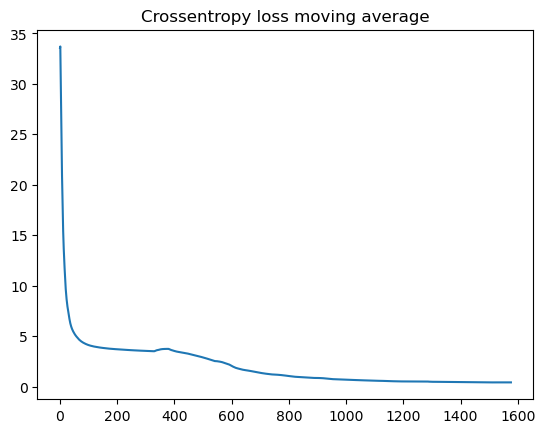

In [176]:
if train:
    
    rolling_length = 50
    
    losses_mov_avg = (
        np.convolve(
            np.array(losses),
            np.ones(rolling_length),
            mode="valid",
        )
        / rolling_length
    )
    
    plt.title("Crossentropy loss moving average")
    plt.plot(losses_mov_avg)

In [177]:
def prompt_model(model, prompt=None, max_new_tokens=200, topk=3):
    model.eval();
    
    # pad the prompt so that it has at least the length of block_size
    # and so that the model is guided into giving an answer
    pre_padding = "Ultimately, what we need to remember is that every person has a unique perspective and experiences that shape their opinions and actions. We must strive to approach each conversation with empathy and understanding, and be willing to listen and learn from one another. Only then can we truly progress and create a better world for ourselves and future generations.\n Unfortunately we only have time for one final question. There is one thing that I have to ask you. \n"
    post_padding = "\nThat's such an interesting question. I think that "
    
    if prompt is None or prompt == "":
        # give zero context
        prompt = ""
    
    context = pre_padding + prompt + post_padding
    
    # convert prompt to a batched tensor
    context_tensor = encode(context)
    context_tensor = torch.unsqueeze(context_tensor, 0)
    
    output = model.generate_to_text(context_tensor, max_new_tokens, topk)
    answer = output
    return answer

In [178]:
prompt = "What do you think about Elon?"
answer = prompt_model(model, prompt, max_new_tokens=100, topk=2)
print(answer)

Ultimately, what we need to remember is that every person has a unique perspective and experiences that shape their opinions and actions. We must strive to approach each conversation with empathy and understanding, and be willing to listen and learn from one another. Only then can we truly progress and create a better world for ourselves and future generations.
 Unfortunately we only have time for one final question. There is one thing that I have to ask you. 
What do you think about Elon?
That's such an interesting question. I think that it's this this a sirasionart of fureareararareartionasionacatias it it with a saicacicactiople it's like this uppaseareampicicici


In [166]:
get_batch(train_data)[0].shape

torch.Size([50, 256])

In [172]:
prompt_model(model, decode(get_batch(train_data)[0][0]), max_new_tokens=100, topk=2)

"Ultimately, what we need to remember is that every person has a unique perspective and experiences that shape their opinions and actions. We must strive to approach each conversation with empathy and understanding, and be willing to listen and learn from one another. Only then can we truly progress and create a better world for ourselves and future generations.\n Unfortunately we only have time for one final question. There is one thing that I have to ask you. \ns a sign of the times being good,\n is that it's just entertaining\n on some unpleasant mammalian level to watch,\n to disagree with others.\n And Twitter and Facebook are actually taking advantage\n of that in a sense because it brings you back\n to the platform and they're advertiser driven,\n so they make a lot of money.\n So you go back and you click.\n Love doesn't sell quite as well in terms of advertisement.\n It doesn't.\n So you've started your career\n at NASA Jet \nThat's such an interesting question. I think that t

### Parameter count and losses for different models

In [41]:
# report the parameters and loss with 5k training steps:

# --- tiny dataset (10k tokens) ---
# bigram model: 3844 ==> loss to 2.5
# with one multihead attention (5 heads): 53262 ==> loss to 0.35
# with one multihead attention (5 heads) and residual connection: 53262 ==> loss to 0.30
# with one full block: 134162 ==> loss to 0.24
# with 5 blocks: 617762 ==> loss to 0.12

# --- large dataset (38M tokens)--- 
# bigger model: 5 015 318 (5M) ==> loss to 0.0116
# large model: 75 892 886 (75M) ==> loss to 0.0074 (4.5h training = 15k steps)
# large model: 75 892 886 (75M) with longer training ==> loss to 0.0067 (20k steps with 3e-4 + 5k steps with 1e-4 lr)

# --- byte-pair encoding
# 3k steps: 0.06048505887389183